In [1]:
# Basic imports
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F

# Sort of a "batteries included" library for pytorch
# Integrates with many useful sklearn tools like GridSearchCV
# Implements boilerplate like early stopping that you might otherwise have to write yourself
# However, because everything is made to be generally useful, it might not exactly fit your needs
import skorch

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
mnist_train_data = MNIST('datasets', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
]))

In [3]:
mnist_test_data = MNIST('datasets', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
]))

In this example we won't actually need data loaders since they are abstracted away by skorch. However, if you need to roll some custom training code, you will need to do this.

In [4]:
mnist_train_data_loader = torch.utils.data.DataLoader(
    mnist_train_data,
    num_workers=4,  # This can be a useful option to speed up training by keeping your GPU "fed"b
    batch_size=32,
    shuffle=True,
)
mnist_test_data_loader = torch.utils.data.DataLoader(
    mnist_test_data,
    num_workers=4,
    batch_size=32,
    shuffle=False,
)

## Initial data exploration
It is often useful to peek at your data. This can be useful to catch weird issues with your data early on, and is often useful for debugging your network later too.

In [5]:
examples = enumerate(mnist_test_data_loader)
i, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([32, 1, 28, 28])

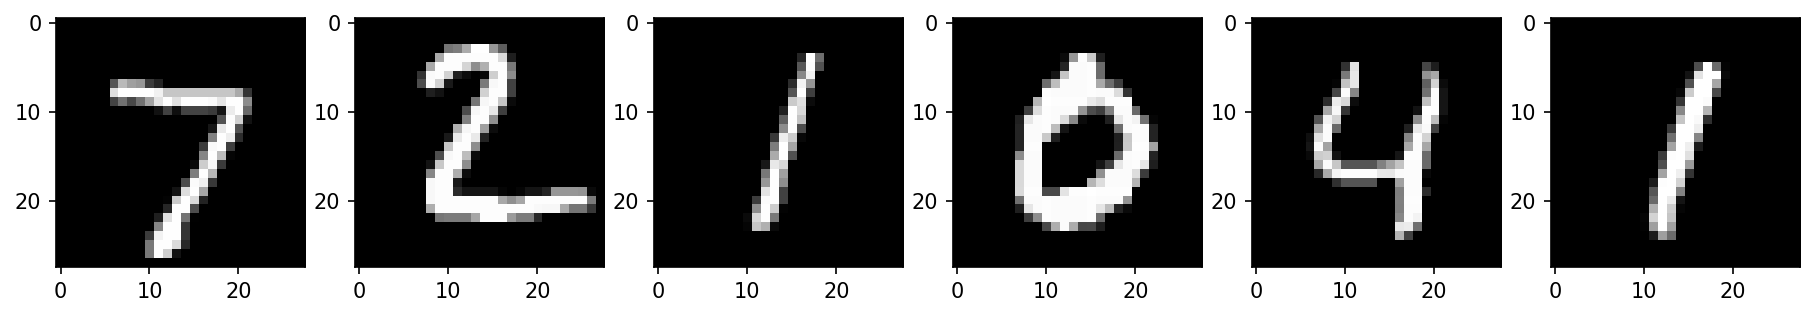

In [7]:
fig, axes = plt.subplots(dpi=150, ncols=6, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(example_data[i][0], cmap='gray', interpolation='none')
fig.show()

In [8]:
class ConvNet(nn.Module):
    def __init__(self, dropout=0.5):
        """
        You need to define the *learning* components of your network here. For example, since
        the ReLU function isn't something we learn, we do not need to instantiate it here.
        """
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout)  # We will need to deal with this later!
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        """
        This is where the model is actually put together
        """
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)  # Reshapes
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)  # This is EXTREMELY IMPORTANT
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # What you use here will dictate what loss function you use!

In [9]:
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.helper import SliceDataset
from skorch.callbacks import ProgressBar, EarlyStopping
from sklearn.model_selection import GridSearchCV

Usually you have to write your own function to train your network. With skorch, this is not necessary, and makes training these a breeze!

In [10]:
torch.manual_seed(1234)  # Because reproducibility is good

net = NeuralNetClassifier(
    ConvNet,
    max_epochs=5,  # You would train many more epochs in practice - this is just a toy example
    iterator_train__num_workers=6,  # Can increase to keep your GPU "fed" with data
    iterator_valid__num_workers=6,
    lr=0.0002,
    device=DEVICE,
    criterion=nn.NLLLoss,  # This is your loss function
    optimizer=torch.optim.Adam,  # This is your optimizer
    batch_size=32,
    callbacks=[
        ProgressBar(),  # Nice visual progress bar as you are training
        EarlyStopping(patience=5, monitor='valid_loss'),  # Stops training if we see no improvement in validation loss for x epochs
    ],
)
y_train = np.array([y for x, y in mnist_train_data])
net.fit(mnist_train_data, y=y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8856       0.9159        0.2769  8.2096


      2        0.3907       0.9496        0.1686  7.9793


      3        0.2891       0.9587        0.1357  7.7666


      4        0.2439       0.9681        0.1117  7.7007


      5        0.2181       0.9705        0.1000  7.6806


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvNet(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  ),
)

In [11]:
from sklearn import metrics
y_pred = net.predict(mnist_test_data)

In [12]:
metrics.accuracy_score(
    [y for x, y in mnist_test_data],
    y_pred,
)

0.9736

## But what about hyperparameters?

In [13]:
net.set_params(max_epochs=5, verbose=False, train_split=False, callbacks=[])
params = {
    'module__dropout': [0, 0.5, 0.8],  # You an expand this section, and all combinations will be tested
}
net.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvNet(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  ),
)

In [14]:
gs = GridSearchCV(net, param_grid=params, scoring='accuracy', verbose=1, cv=3)

In [15]:
mnist_train_sliceable = SliceDataset(mnist_train_data)  # Helper class that wraps a torch dataset to make it work with sklearn.

In [16]:
gs.fit(mnist_train_sliceable, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvNet(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  ),
),
             iid='warn', n_jobs=None,
             param_grid={'module__dropout': [0, 0.5, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [17]:
gs.best_params_

{'module__dropout': 0}